# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sb

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

display(df.head())
display(df_content.head())

del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
display(df.head())
display(df_content.head())

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [712]:
df.shape

(45993, 3)

In [713]:
df_content.shape

(1056, 5)

In [714]:
df['email'].head()

0    ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1    083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2    b96a4f2e92d8572034b1e9b28f9ac673765cd074
3    06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4    f01220c46fc92c6e6b161b1849de11faacd7ccb2
Name: email, dtype: object

In [715]:
df.sort_values('article_id', ascending=False).head()

,article_id,title,email
21382,1444.0,worldwide fuel oil consumption by household (i...,d313c83ab3ed388ba16042a6cd33fce57d6a9e9a
27402,1444.0,worldwide fuel oil consumption by household (i...,c45f9495a76bf95d2633444817f1be8205ad542d
30249,1444.0,worldwide fuel oil consumption by household (i...,6cce7568da5452718e1a3702edffac34a8da74ec
17095,1444.0,worldwide fuel oil consumption by household (i...,d5843ed71361c87b364f578f20a48101289d60f9
2374,1444.0,worldwide fuel oil consumption by household (i...,fd824fc62b4753107e3db7704cd9e8a4a1c961f1


In [716]:
df.groupby('email').count().head()

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [717]:
user_segmented = df.groupby('email').count().sort_values('title', ascending=False)
user_segmented.head()

,article_id,title
email,,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364,364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363,363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170,170
a37adec71b667b297ed2440a9ff7dad427c7ac85,169,169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160,160


In [718]:
user_segmented_id = df.groupby('email').count().sort_values('title', ascending=False)['article_id'] # emails with highest articles
user_segmented_id.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

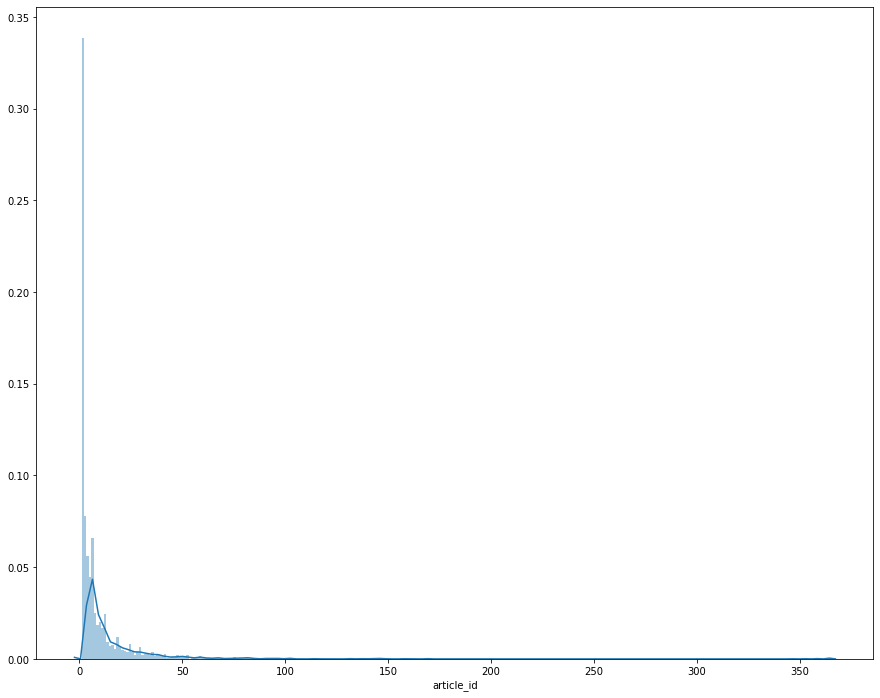

In [719]:
plt.figure(figsize=(15,12))
sb.distplot(user_segmented_id, bins=300)
plt.show()

In [720]:
user_segmented.shape

(5148, 2)

In [721]:
user_segmented.info

<bound method DataFrame.info of                                           article_id  title
email                                                      
2b6c0f514c2f2b04ad3c4583407dccd0810469ee         364    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a         363    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66         170    170
a37adec71b667b297ed2440a9ff7dad427c7ac85         169    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93         160    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76         158    158
284d0c17905de71e209b376e3309c0b08134f7e2         148    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc         147    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c         147    147
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3         145    145
c60bb0a50c324dad0bffd8809d121246baef372b         145    145
56832a697cb6dbce14700fca18cffcced367057f         144    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388         142    142
ceef2a24a2a82031246814b73e029edba51e8ea9         140    140
8dc8d7ec

In [722]:
user_segmented.describe()

,article_id,title
count,5148.000000,5148.000000
mean,8.930847,8.930847
std,16.802267,16.802267
min,1.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,3.000000
75%,9.000000,9.000000
max,364.000000,364.000000


In [723]:
user_segmented.median()

article_id    3.0
title         3.0
dtype: float64

In [724]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [725]:
df_content.shape

(1056, 5)

In [726]:
df_content.head(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [727]:
df_content.groupby('doc_status').count()

,doc_body,doc_description,doc_full_name,article_id
doc_status,,,,
Live,1042,1053,1056,1056


In [728]:
# Find and explore duplicate articles
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [729]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

In [730]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [731]:
df.shape

(45993, 3)

In [732]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [733]:
df_content.shape

(1051, 5)

In [734]:
df_content.nunique()

doc_body           1031
doc_description    1019
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [735]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [736]:
# groupby article_id, then find article_id with highest emails (hence users)
df.groupby('article_id').count().sort_values('email', ascending=False).head(10)

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


In [737]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [738]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [739]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [740]:
# testing

# get top n titles
temp = df.groupby('title').count().sort_values('user_id', ascending=False).head(10)

In [741]:
# extract titles
temp2 = temp.index
temp2

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')

In [742]:
temp2 = list(temp2)
temp2

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [743]:
# get top n article id's
temp = df.groupby('article_id').count().sort_values('user_id', ascending=False).head(10)
temp2 = list(temp.index)
temp2

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [744]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    # get dataset for top n titles
    temp = df.groupby('title').count().sort_values('user_id', ascending=False).head(n)
    
    # extract titles
    top_articles = list(temp.index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # get dataset for top n article id's
    temp = df.groupby('article_id').count().sort_values('user_id', ascending=False).head(n)
    
    # extract id's
    top_articles = list(temp.index)
 
    return top_articles # Return the top article ids

In [745]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [746]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [747]:
# testing
df.head(10)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
5,1432.0,visualize data with the matplotlib library,6
6,1429.0,use deep learning for image classification,7
7,593.0,upload files to ibm data science experience us...,8
8,1314.0,healthcare python streaming application demo,9
9,1185.0,classify tumors with machine learning,10


In [748]:
df_content.head(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [749]:
df.groupby(['user_id','article_id']).count().head(50) # get an idea of what each user reads what

title
user_id article_id       
1       43.0            1
        109.0           1
        151.0           1
        268.0           1
        310.0           2
        329.0           1
        346.0           1
        390.0           1
        494.0           1
        525.0           1
        585.0           2
        626.0           1
        668.0           2
        732.0           1
        768.0           1
        910.0           1
        968.0           1
        981.0           1
        1052.0          2
        1170.0          2
        1183.0          2
        1185.0          2
        1232.0          1
        1293.0          1
        1305.0          1
        1363.0          2
        1368.0          1
        1391.0          1
        1400.0          1
        1406.0          2
        1427.0          1
        1429.0          1
        1430.0          2
        1431.0          2
        1436.0          1
        1439.0          1
2       1024.0          1
        1176.0          1
        1305.0          1
        1314.0          1
        1422.0          1
        1427.0          1
3       12.0            1
        20.0            1
        29.0            1
        43.0            1
        50.0            2
        62.0            1
        109.0           1
        116.0           1

In [750]:
temp = df.groupby(['user_id','article_id']).agg(lambda x: 1) # convert each of these to counts to 1
temp.head(50)

title
user_id article_id       
1       43.0            1
        109.0           1
        151.0           1
        268.0           1
        310.0           1
        329.0           1
        346.0           1
        390.0           1
        494.0           1
        525.0           1
        585.0           1
        626.0           1
        668.0           1
        732.0           1
        768.0           1
        910.0           1
        968.0           1
        981.0           1
        1052.0          1
        1170.0          1
        1183.0          1
        1185.0          1
        1232.0          1
        1293.0          1
        1305.0          1
        1363.0          1
        1368.0          1
        1391.0          1
        1400.0          1
        1406.0          1
        1427.0          1
        1429.0          1
        1430.0          1
        1431.0          1
        1436.0          1
        1439.0          1
2       1024.0          1
        1176.0          1
        1305.0          1
        1314.0          1
        1422.0          1
        1427.0          1
3       12.0            1
        20.0            1
        29.0            1
        43.0            1
        50.0            1
        62.0            1
        109.0           1
        116.0           1

In [751]:
df.groupby(['user_id','article_id']).agg(lambda x: 1).unstack().head(5)

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3             NaN    NaN    NaN    NaN    NaN    1.0    NaN    NaN    NaN   
4             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             NaN  ...    NaN    NaN    1.0    NaN    1.0    NaN    NaN   
2             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3             NaN  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN   
4             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5             NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             NaN    NaN    NaN  
2             NaN    NaN    NaN  
3             NaN    NaN    NaN  
4             NaN    NaN    NaN  
5             NaN    NaN    NaN  

[5 rows x 714 columns]

In [752]:
df.groupby(['user_id','article_id']).agg(lambda x: 1).unstack().head(5).fillna(0)

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

In [753]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # groupby each user and return 1 for each unique article read
    temp = df.groupby(['user_id','article_id']).title.agg(lambda x: 1)
    # make table
    temp = temp.unstack()
    # replace NaN with 0
    user_item = temp.fillna(0).astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [754]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [755]:
# testing
user_item.head(10)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [756]:
np.dot([1,2],[3,4]) # dot product test

11

In [757]:
user_item.iloc[1,:].head(10) # print 1+1-th row

article_id
0.0     0
2.0     0
4.0     0
8.0     0
9.0     0
12.0    0
14.0    0
15.0    0
16.0    0
18.0    0
Name: 2, dtype: int64

In [758]:
user_item.loc[1,:].head(10) # print row for index = user_id = 1

article_id
0.0     0
2.0     0
4.0     0
8.0     0
9.0     0
12.0    0
14.0    0
15.0    0
16.0    0
18.0    0
Name: 1, dtype: int64

In [759]:
sum((user_item.loc[1,:])**2) # u.u = |u|^2 check

36

In [760]:
np.dot(user_item.loc[1,:], user_item.loc[1,:]) # check

36

In [761]:
# for given user_id, compute similarity vs every other user. Dict approach
similarity = {}
for user in user_item.index:
    similarity[user] = np.dot(user_item.loc[1, :], user_item.loc[user, :])
similarity # verify row 1 = u.u = |u|^2 = 36

{1: 36,
 2: 2,
 3: 6,
 4: 3,
 5: 0,
 6: 4,
 7: 1,
 8: 6,
 9: 4,
 10: 7,
 11: 5,
 12: 0,
 13: 3,
 14: 1,
 15: 1,
 16: 0,
 17: 2,
 18: 0,
 19: 0,
 20: 0,
 21: 9,
 22: 5,
 23: 17,
 24: 5,
 25: 0,
 26: 5,
 27: 1,
 28: 6,
 29: 0,
 30: 1,
 31: 1,
 32: 1,
 33: 2,
 34: 2,
 35: 3,
 36: 1,
 37: 4,
 38: 7,
 39: 0,
 40: 9,
 41: 4,
 42: 2,
 43: 2,
 44: 3,
 45: 5,
 46: 13,
 47: 0,
 48: 3,
 49: 12,
 50: 0,
 51: 2,
 52: 9,
 53: 0,
 54: 7,
 55: 4,
 56: 4,
 57: 4,
 58: 7,
 59: 1,
 60: 7,
 61: 2,
 62: 0,
 63: 5,
 64: 8,
 65: 5,
 66: 2,
 67: 7,
 68: 1,
 69: 6,
 70: 0,
 71: 2,
 72: 7,
 73: 0,
 74: 3,
 75: 1,
 76: 2,
 77: 1,
 78: 0,
 79: 1,
 80: 0,
 81: 0,
 82: 5,
 83: 0,
 84: 0,
 85: 4,
 86: 3,
 87: 6,
 88: 5,
 89: 3,
 90: 6,
 91: 1,
 92: 3,
 93: 0,
 94: 3,
 95: 3,
 96: 0,
 97: 0,
 98: 10,
 99: 1,
 100: 0,
 101: 0,
 102: 0,
 103: 3,
 104: 2,
 105: 1,
 106: 0,
 107: 3,
 108: 0,
 109: 1,
 110: 2,
 111: 6,
 112: 2,
 113: 6,
 114: 5,
 115: 1,
 116: 0,
 117: 0,
 118: 1,
 119: 0,
 120: 3,
 121: 3,
 122: 4,
 123:

In [762]:
# pandas series approach
similarity = user_item.dot(user_item.loc[1])
similarity

user_id
1       36
2        2
3        6
4        3
5        0
6        4
7        1
8        6
9        4
10       7
11       5
12       0
13       3
14       1
15       1
16       0
17       2
18       0
19       0
20       0
21       9
22       5
23      17
24       5
25       0
26       5
27       1
28       6
29       0
30       1
        ..
5120     1
5121     0
5122     0
5123     1
5124     4
5125     0
5126     0
5127     1
5128     1
5129     3
5130     0
5131     0
5132     0
5133     0
5134     1
5135     0
5136     1
5137     0
5138     9
5139     0
5140     7
5141     0
5142     0
5143     4
5144     0
5145     1
5146     0
5147     0
5148     0
5149     0
Length: 5149, dtype: int64

In [763]:
similarity = similarity.sort_values(ascending=False)
similarity

user_id
1       36
3933    35
23      17
3782    17
203     15
4459    15
131     14
3870    14
46      13
4201    13
5041    12
49      12
3697    12
395     12
3910    11
322     11
3622    11
242     11
4642    10
290     10
2982    10
912     10
3540    10
98      10
754     10
3764    10
256      9
52       9
268      9
40       9
        ..
2906     0
2909     0
2954     0
2910     0
2952     0
2951     0
2950     0
2947     0
2945     0
2944     0
2943     0
2942     0
2939     0
2938     0
2937     0
2936     0
2933     0
2931     0
2930     0
2929     0
2928     0
2927     0
2923     0
2922     0
2921     0
2920     0
2918     0
2916     0
2911     0
2575     0
Length: 5149, dtype: int64

In [764]:
similarity = similarity.index
similarity

Int64Index([   1, 3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201,
            ...
            2928, 2927, 2923, 2922, 2921, 2920, 2918, 2916, 2911, 2575],
           dtype='int64', name='user_id', length=5149)

In [765]:
similarity = similarity.drop(2575)
similarity

Int64Index([   1, 3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201,
            ...
            2929, 2928, 2927, 2923, 2922, 2921, 2920, 2918, 2916, 2911],
           dtype='int64', name='user_id', length=5148)

In [766]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    temp = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    temp = temp.sort_values(ascending=False)
    
    # create list of just the ids
    temp = temp.index
   
    # remove the own user's id
    most_similar_users = temp.drop(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [767]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Int64Index([3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Int64Index([1, 23, 3782, 4459, 203], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Int64Index([4201, 23, 3782], dtype='int64', name='user_id')


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [768]:
# testing for fn get_article_names
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [769]:
df[df.article_id==0].title

1935     detect malfunctioning iot sensors with streami...
1936     detect malfunctioning iot sensors with streami...
1937     detect malfunctioning iot sensors with streami...
1973     detect malfunctioning iot sensors with streami...
2302     detect malfunctioning iot sensors with streami...
2328     detect malfunctioning iot sensors with streami...
17440    detect malfunctioning iot sensors with streami...
19242    detect malfunctioning iot sensors with streami...
19444    detect malfunctioning iot sensors with streami...
25884    detect malfunctioning iot sensors with streami...
27888    detect malfunctioning iot sensors with streami...
30815    detect malfunctioning iot sensors with streami...
40755    detect malfunctioning iot sensors with streami...
42948    detect malfunctioning iot sensors with streami...
Name: title, dtype: object

In [770]:
df[df.article_id==0].title.iloc[0]

'detect malfunctioning iot sensors with streaming analytics'

In [771]:
df.head(50).sort_values('article_id')

,article_id,title,user_id
16,12.0,timeseries data analysis of iot events by usin...,11
11,14.0,got zip code data? prep it for analytics. – ib...,12
39,173.0,"10 must attend data science, ml and ai confere...",29
19,173.0,"10 must attend data science, ml and ai confere...",17
38,189.0,common excel tasks demonstrated in pandas,8
30,194.0,data science for real-time streaming analytics,6
28,362.0,dsx: hybrid mode,23
33,460.0,web picks - dataminingapps,26
15,542.0,getting started with python,14
27,593.0,upload files to ibm data science experience us...,22


In [772]:
article_names = []
article_ids = [1430, 1432]
for a_id in article_ids:
    name = df[df.article_id==a_id].title.iloc[0]
    print(name)
    article_names.append(name)
article_names

using pixiedust for fast, flexible, and easier data analysis and experimentation
visualize data with the matplotlib library


['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'visualize data with the matplotlib library']

In [773]:
# testing for fn get_user_articles

In [774]:
user_item.loc[1].head(5) # first 5 articles for user w/ index 1

article_id
0.0    0
2.0    0
4.0    0
8.0    0
9.0    0
Name: 1, dtype: int64

In [775]:
article_ids

[1430, 1432]

In [776]:
user_item.head(5)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [777]:
# get full 0 and 1 data for article ids for user id = 1
article_id_1 = user_item.loc[1,:]  # row for user_id = 1. This is 0 and 1's for all articles
article_id_1 = user_item.loc[1]
print(article_id_1.head(5))

# get id's of articles seen by user id = 1
article_ids = [str(a_id) for a_id in article_id_1[article_id_1==1].index] 
print(article_ids)

 # get names of articles seen by user
article_names = get_article_names(article_ids)
print(article_names)

article_id
0.0    0
2.0    0
4.0    0
8.0    0
9.0    0
Name: 1, dtype: int64
['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0', '585.0', '626.0', '668.0', '732.0', '768.0', '910.0', '968.0', '981.0', '1052.0', '1170.0', '1183.0', '1185.0', '1232.0', '1293.0', '1305.0', '1363.0', '1368.0', '1391.0', '1400.0', '1406.0', '1427.0', '1429.0', '1430.0', '1431.0', '1436.0', '1439.0']
['deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'jupyter notebook tutorial', 'sector correlations shiny app', 'time series prediction using recurrent neural networks (lstms)', 'introduction to market basket analysis in\xa0python', 'fighting gerrymandering: using data science to draw fairer congressional districts', 'introducing ibm watson studio ', 'python for loops explained (python for data science basics #5)', 'new shiny cheat sheet and video tutorial', 'tidyverse practice: mapping large european cities', 'analyze db2 warehouse on

In [778]:
# testing for fn user_user_recs

In [779]:
recs = []
m = 10
user_id = 1
most_similar_users = find_similar_users(user_id) # get most similar users to input user
print('most_similar_users: \n', most_similar_users,'\n')
    
article_ids_inputuser, article_names_inputuser = get_user_articles(user_id) # get articles input user read
print('input users article ids: \n', article_ids_inputuser,'\n')
print('input users article names: \n', article_names_inputuser,'\n')
for user in most_similar_users: # get articles similar users read, and recommend to input user if they have not read it AND it hasnt hit recomm limit
    article_ids, article_names = get_user_articles(user)
    for id in article_ids:
        if id not in article_ids_inputuser:
              recs.append(id)
        if len(recs) >= m:
             break
    if len(recs) >= m:
            break
    
if len(recs) < m:
    for id in str(df['article_id']):
        if id not in article_ids_inputuser:
            recs.append(id)
        if len(recs) >= m:
                break
recs

most_similar_users: 
 Int64Index([3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201, 5041,
            ...
            2928, 2927, 2923, 2922, 2921, 2920, 2918, 2916, 2911, 2575],
           dtype='int64', name='user_id', length=5148) 

input users article ids: 
 ['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0', '585.0', '626.0', '668.0', '732.0', '768.0', '910.0', '968.0', '981.0', '1052.0', '1170.0', '1183.0', '1185.0', '1232.0', '1293.0', '1305.0', '1363.0', '1368.0', '1391.0', '1400.0', '1406.0', '1427.0', '1429.0', '1430.0', '1431.0', '1436.0', '1439.0'] 

input users article names: 
 ['deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'jupyter notebook tutorial', 'sector correlations shiny app', 'time series prediction using recurrent neural networks (lstms)', 'introduction to market basket analysis in\xa0python', 'fighting gerrymandering: using data science to draw fairer congressional districts', 'i

['2.0', '12.0', '14.0', '16.0', '26.0', '28.0', '29.0', '33.0', '50.0', '74.0']

In [780]:
# check users who read article_id 2.0 out of curiosity
df[df.article_id==43.0]

,article_id,title,user_id
271,43.0,deep learning with tensorflow course by big da...,24
329,43.0,deep learning with tensorflow course by big da...,28
459,43.0,deep learning with tensorflow course by big da...,186
515,43.0,deep learning with tensorflow course by big da...,11
659,43.0,deep learning with tensorflow course by big da...,207
736,43.0,deep learning with tensorflow course by big da...,244
1002,43.0,deep learning with tensorflow course by big da...,204
1312,43.0,deep learning with tensorflow course by big da...,64
1355,43.0,deep learning with tensorflow course by big da...,22
1554,43.0,deep learning with tensorflow course by big da...,90


In [781]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column) 
    '''
    # Your code heren
    article_names = []
    
    # cycle through every id in article_ids
    for a_id in article_ids:
        # grab all instances when id occurs, and just select top one
        name = df[df.article_id==float(a_id)].title.iloc[0]
#         print("Article {}", name, "added.")
        article_names.append(name)
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''


    # Your code heren
    # extract full row from user_item for chosen user
    input_user_row = user_item.loc[user_id]
    # extract article id's only for the 1's in that row
    article_ids = [str(a_id) for a_id in input_user_row[input_user_row == 1].index]
    # convert those article_ids into titles
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    
    # Your code jhere
    
    recs = []
    # extract similar users to input user
    most_similar_users = find_similar_users(user_id)
    
    # get input user's read articles
    input_art_ids, input_art_names = get_user_articles(user_id)
    
    # extract all the articles read by similar users, and recommend if input user has not read until list is full up to m
    for user in most_similar_users:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in input_art_ids:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break
    if len(recs) < m:
        for id in str(df['article_id']):
            if id not in input_art_ids:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    return recs # return your recommendations for this user_id   

In [782]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [783]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [784]:
df_content.nunique()

doc_body           1031
doc_description    1019
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [785]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    for user in user_item.index:
        if user == user_id:
            continue
        neighbors_df.loc[user] = [user, np.dot(user_item.loc[user_id, :], user_item.loc[user, :]),
                                  df[df['user_id']==user]['article_id'].count()]
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    
    # extract similar users based on neighbours instead of most_similar_users
    neighbors_df = get_top_sorted_users(user_id)

    # get input user's read articles
    input_art_id, input_art_names = get_user_articles(user_id)
    
    # extract articles read by neighbours, recommend if input user has not read until list is full up tom
    for user in neighbors_df['neighbor_id']:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in input_art_id:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break
    if len(recs) < m:
        for id in [str(id) for id in get_top_article_ids(1051)]: # choose recommendations based on top articles
            if id not in input_art_id:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    rec_names = get_article_names(recs) # get names due to extract return output
    
    return recs, rec_names # return names along with article ids







In [786]:
# original user_user_recs
#     # Your code here
#     recs = []
#     # extract similar users to input user
#     most_similar_users = find_similar_users(user_id)
    
#     # get input user's read articles
#     input_art_ids, input_art_names = get_user_articles(user_id)
    
#     # extract all the articles read by similar users, and recommend if input user has not read until list is full up to m
#     for user in most_similar_users:
#         article_ids, article_names = get_user_articles(user)
#         for id in article_ids:
#             if id not in input_art_ids:
#                 recs.append(id)
#             if len(recs) >= m:
#                 break
#         if len(recs) >= m:
#                 break
#     if len(recs) < m:
#         for id in str(df['article_id']):
#             if id not in input_art_ids:
#                 recs.append(id)
#             if len(recs) >= m:
#                     break
    
#     return recs # return your recommendations for this user_id   

In [787]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [788]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1
print(user1_most_sim)
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131
print(user131_10th_sim)

3933
242


In [789]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Because the user is new and we don't have any data on them, I'd suggest showing the most popular articles across the whole user base (using get_top_article_ids(10)). To address this cold start problem, we could use a knowledge-based or content-based recommendation engine.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [790]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs_float = get_top_article_ids(10) # Your recommendations here

new_user_recs = []
for e in new_user_recs_float:
    new_user_recs.append(str(e))
print(new_user_recs)


['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [791]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [792]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [793]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [794]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [795]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [796]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**FunkSVD is a good solution for user-item matrix with lots of NaNs. In the Udacity lessons, the matrix comprised user ratings and NaN values that represented an absence of ratings. Here, our matrix comprises 0 and 1 and no NaNs, so that SVD becomes feasible.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

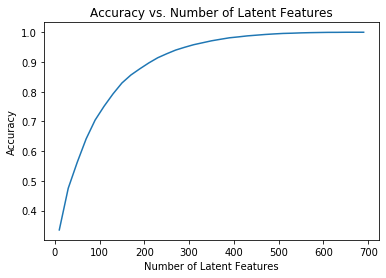

In [797]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [798]:
# testing
df_train = df.head(40000)
df_test = df.tail(5993)
user_item_test = create_user_item_matrix(df_test)
user_item_test.head(10)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [799]:
test_idx = list(user_item_test.index)
test_idx[:5]

[2917, 3024, 3093, 3193, 3527]

In [800]:
test_arts = list(user_item_test.columns)
test_arts[:5]

[0.0, 2.0, 4.0, 8.0, 9.0]

In [801]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [802]:
# total USERS in test set
users_test = len(df_test['user_id'].unique())
users_test

682

In [803]:
# check
len(test_idx)

682

In [804]:
# How many USERS can we make predictions for in the test set?

# number USERS in test set we CAN make predictions on
# common users in train and test set
users_OK = len(np.intersect1d(df_train['user_id'].unique(), df_test['user_id'].unique()))
users_OK

20

In [805]:
# check
user_item_train.index.isin(test_idx).sum()

20

In [806]:
# How many USERS in the test set are we not able to make predictions for because of the cold start problem?

# number USERS CANT make predictions on
# number users outside of intersection
users_test - users_OK

662

In [807]:
# total ARTICLES in test set
articles_test = len(df_test['article_id'].unique())
articles_test

574

In [808]:
# check
len(test_arts)

574

In [809]:
# How many ARTICLES can we make predictions for in the test set?

# number ARTICLES in test set we CAN make predictions on
# common articles in train and test set
articles_OK = len(np.intersect1d(df_train['article_id'].unique(), df_test['article_id'].unique()))
articles_OK

574

In [810]:
# check
user_item_train.columns.isin(test_arts).sum()

574

In [811]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?

# number ARTICLES CANT make predictions on
# number articles outside of intersection
articles_test - articles_OK

0

In [812]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [813]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [814]:
u_train.shape

(4487, 4487)

In [815]:
s_train.shape

(714,)

In [816]:
vt_train.shape

(714, 714)

In [817]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [818]:
# Users/articles in user_item_train matrix
train_idx = np.array(user_item_train.index)
print(train_idx, "\n")
train_arts = np.array(user_item_train.columns)
print(train_arts)

[   1    2    3 ... 4485 4486 4487] 

[   0.    2.    4.    8.    9.   12.   14.   15.   16.   18.   20.   25.
   26.   28.   29.   30.   32.   33.   34.   36.   39.   40.   43.   48.
   50.   51.   53.   54.   57.   58.   59.   60.   62.   64.   65.   68.
   74.   76.   77.   78.   80.   81.   82.   87.   89.   92.   96.   98.
  100.  101.  102.  103.  107.  108.  109.  110.  111.  112.  113.  115.
  116.  117.  120.  122.  124.  125.  130.  131.  132.  134.  136.  138.
  142.  143.  145.  146.  151.  152.  153.  157.  158.  162.  164.  173.
  176.  181.  183.  184.  188.  189.  191.  193.  194.  195.  202.  205.
  210.  213.  215.  221.  223.  224.  225.  230.  232.  233.  234.  236.
  237.  239.  240.  241.  244.  250.  251.  252.  253.  254.  256.  258.
  260.  263.  266.  268.  270.  273.  277.  278.  283.  284.  288.  291.
  295.  297.  298.  299.  302.  303.  310.  311.  313.  314.  315.  316.
  319.  323.  324.  329.  330.  336.  337.  339.  346.  347.  348.  349.
  350.  351. 

In [819]:
# Users/articles in train/test intersection (test set rows that are also in training)
test_idx_intersect = np.intersect1d(test_idx, train_idx)
print(test_idx_intersect, "\n")
test_arts_intersect = np.intersect1d(test_arts, train_arts)
print(test_arts_set)

[2917 3024 3093 3193 3527 3532 3684 3740 3777 3801 3968 3989 3990 3998
 4002 4204 4231 4274 4293 4487] 

[   0.    2.    4.    8.    9.   12.   14.   15.   16.   18.   20.   25.
   26.   28.   29.   30.   32.   33.   34.   36.   39.   40.   43.   48.
   50.   51.   53.   54.   57.   58.   59.   60.   62.   64.   65.   68.
   74.   76.   77.   78.   80.   81.   82.   87.   89.   92.   96.   98.
  100.  101.  102.  103.  107.  108.  109.  110.  111.  112.  113.  115.
  116.  117.  120.  122.  124.  125.  130.  131.  132.  134.  136.  138.
  142.  143.  145.  146.  151.  152.  153.  157.  158.  162.  164.  173.
  176.  181.  183.  184.  188.  189.  191.  193.  194.  195.  202.  205.
  210.  213.  215.  221.  223.  224.  225.  230.  232.  233.  234.  236.
  237.  239.  240.  241.  244.  250.  251.  252.  253.  254.  256.  258.
  260.  263.  266.  268.  270.  273.  277.  278.  283.  284.  288.  291.
  295.  297.  298.  299.  302.  303.  310.  311.  313.  314.  315.  316.
  323.  324.  329. 

In [820]:
# Users/articles positions of test set within TRAINING matrix
train_indices = np.where(np.in1d(train_idx, test_idx_intersect))[0]
print(train_indices, "\n")
train_articles = np.where(np.in1d(train_arts, test_arts_intersect))[0]
print(train_articles)

[2916 3023 3092 3192 3526 3531 3683 3739 3776 3800 3967 3988 3989 3997
 4001 4203 4230 4273 4292 4486] 

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 145 146 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 167 168 169 171 172 173 174 175 176 177 178 179 180 181 183 184 185 186
 187 190 191 192 193 197 198 200 202 203 204 205 206 207 208 209 210 211
 213 214 216 217 218 219 220 222 223 224 225 228 229 230 232 233 234 235
 236 239 240 241 24

In [821]:
# User positions of test set within TEST matrix
test_indices = np.where(np.in1d(test_idx, test_idx_intersect))[0]
print(test_indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [822]:
# Subset of user-item matrix containing only the user-articles in train/set intersection
u_item_test_intersect = user_item_test.iloc[test_indices,:]
print(u_item_test_intersect, "\n")
u_item_train_intersect = user_item_train.iloc[train_indices, train_articles]
print(u_item_train_intersect)

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
2917             0       0       0       0       0       0       0       0   
3024             0       0       0       0       0       1       0       0   
3093             0       0       0       0       0       0       0       0   
3193             0       0       0       0       0       0       0       0   
3527             0       0       0       0       0       0       0       0   
3532             0       0       0       0       0       1       0       0   
3684             0       0       0       0       0       0       0       0   
3740             0       0       0       0       0       1       0       0   
3777             0       0       0       0       0       0       0       0   
3801             0       0       0       0       0       1       0       0   
3968             0       0       0       0       0       0      

In [823]:
num_latent_feats = np.arange(10,500+70,10)
sum_errs = []

for k in num_latent_feats:
    # Restructure train matrices with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Restructure test matrices with k latent features
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # Calculate dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Calculate error (prediction against actual)
    incremental_error = u_item_test_set - u_item_test_set_pred
    
    # Total error tracking
    total_error = np.sum(np.sum(np.abs(incremental_error)))
    sum_errs.append(total_error)

11480


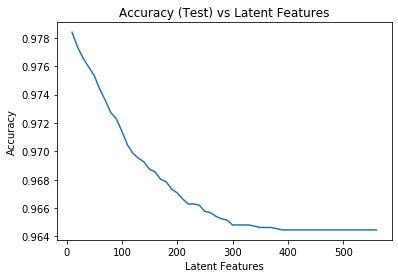

In [824]:
# Plot accuracy vs latent features for TEST set
print(u_item_test_set.shape[0] * u_item_test_set.shape[1]) # interactions
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / (u_item_test_set.shape[0] * u_item_test_set.shape[1]))
plt.xlabel('Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy (Test) vs Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Comparing plots, we see the accuracy increases as the number of latent features in the training set increases in contrast to the accuracy decreasing for the test set. This looks like an overfitting problem, perhaps caused by only having 20 users common in both training and test set. In other words, we simply don't have enough quality data for the algorithm to learn a clean signal.**

**We can follow up with some A/B testing, for instance comparing a rank based recommender vs the matrix recommender above, testing for statistical and practical differences. It may be that a collaborative or content-based system works better here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [825]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

255